## Linear Regression Tutorial, Part 1: Simple Linear Regression

RJ Nowling

In this tutorial, we'll go over how to build a simple linear regression model and evaluate it.  For this exercise, we'll use a data set of 945 real estate transactions in Sacremento, CA.

We'll start by importing the various libraries we'll need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

%matplotlib inline

### Load and Clean Data

Before we can build any models, we need to import the data and clean it by converting types as necessary.

In [2]:
df = pd.read_csv("Sacramentorealestatetransactions.csv")

In [3]:
df.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


In [4]:
df.dtypes

street        object
city          object
zip            int64
state         object
beds           int64
baths          int64
sq__ft         int64
type          object
sale_date     object
price          int64
latitude     float64
longitude    float64
dtype: object

For this part of the tutorial, we're only going to use the `sq__ft` variable, so we don't need to transform anything right now.  Let's check if there are any records missing a value for this field.

In [5]:
df["sq__ft"].isnull().sum()

0

The data doesn't appear to have any missing data.  Let's check the histogram just to make sure.

C:\Users\nowling\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


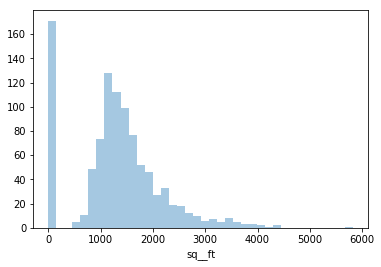

In [6]:
sns.distplot(df["sq__ft"], kde=False)

The data set has a number of transactions with 0 squared footage.  This might be missing data represented as zeros.  We're not gonna handle this now -- we'll handle it later on.

## Experimental Setup

Our goal is to build a predictive model.  Predictive models are applied to data where the outcome variable is unknown.  To accurately evaluate our model, we need to see how it performs on unseen data.  We simulate this by dividing our data set into two groups: a training set (75%) and a testing set (25%).  For this linear regression model, we'll use a simple scheme of random assignment.  

In [7]:
df_train, df_test = train_test_split(df)
print(df.shape[0], df_train.shape[0], df_test.shape[0])

985 738 247


The `fit` method of Scikit Learn API takes two parameters: a feature matrix of floats commonly called `X` and a 1D vector of outcome variables commonly called `y`.  Let's create these from the DataFrames.

In [8]:
X_train = df_train[["sq__ft"]].astype("float64").values
X_test = df_test[["sq__ft"]].astype("float64").values
y_train = df_train["price"].values
y_test = df_test["price"].values

print(type(X_train), X_train.shape, X_train.dtype)
print(type(y_train), y_train.shape, y_train.dtype)

<class 'numpy.ndarray'> (738, 1) float64
<class 'numpy.ndarray'> (738,) int64


## Base Model

When evaluating the importance of a feature (squared footage in this case), it's useful to have a "baseline" to compare against.  In the case of a Linear Regression model with 1 variable, the only baseline is a Linear Regression with no variables -- just an intercept.  The equation we will fit is:

$$
\hat{y} = \beta_0
$$

where $\hat{y}$ is the predicted price and $\beta_0$ is a constant (the intercept).

We can actually interpret the intercept in this case (when there are no variables) as the average price.  The baseline model will return the same value for transaction.  We can build such a model by creating a feature matrix of all zeros.

In [9]:
zeros_train = np.zeros(X_train.shape)
zeros_test = np.zeros(X_test.shape)

Scikit Learn provides multiple Linear Regression models through the `LinearRegression` and `SGDRegressor` classes.  The `SGDRegressor` class is a bit more flexible, so we'll use that.  We train the model on the training set by calling the `fit` method.

In [10]:
base_lr = SGDRegressor(max_iter=5000)
base_lr.fit(zeros_train, y_train)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=5000, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

We now apply the model to the testing set to predict the prices.  Note that the `predict` method only takes the features, not the known prices!

In [11]:
pred_prices_base_test = base_lr.predict(zeros_test)

We evaluate the model by looking at the errors between the predicted $\hat{y}$ and true $y$ prices.  For linear regression models, a metric called mean squared error (MSE) is commonly used:

$$MSE = \frac{1}{N} \sum_{i=0}^{N-1} (y_i - \hat{y}_i)^2$$

A second metric called root-mean squared error (RMSE) is a bit easier to interpret since the errors are in the same units as the prices.  We find the RMSE by taking the square root of the MSE.

$$RMSE = \sqrt{\frac{1}{N} \sum_{i=0}^{N-1} (y_i - \hat{y}_i)^2}$$

In [12]:
base_mse = mean_squared_error(y_test, pred_prices_base_test)
base_rmse = np.sqrt(base_mse)

print("Base Model MSE:", base_mse)
print("Base Model RMSE:", base_rmse)

Base Model MSE: 19650625858.44129
Base Model RMSE: 140180.69003411738


On average, the squared error between the predicted and true price for each transaction is \$128,368.  That's a lot!  Let's look at differences between the predictions and true values using a scatter plot.

Text(0,0.5,'Predicted Price')

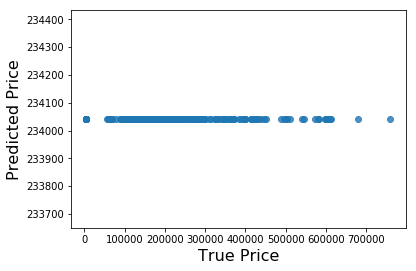

In [13]:
sns.regplot(x=y_test, y=pred_prices_base_test, fit_reg=False)
plt.xlabel("True Price", fontsize=16)
plt.ylabel("Predicted Price", fontsize=16)

Since the base model doesn't have any variables, it predicts the same price for all transactions.  The predicted price is the average price of all transactions in the training set.

## Simple Linear Regression Model

Now, we will fit a simpler linear regression model.  A simple linear regression model has a single variable:

$$
\hat{y} = \beta_1 x_1 + \beta_0
$$

where $\hat{y}$ is the predicted price, $x_1$ will be the squared footage, and $\beta_1$ and $\beta_0$ are coefficients fit by the model based on the data.

First, we'll need to handle the missing value.  Scikit Learn provides a transformer called `Imputer` that can replace missing values with the average value computed from the data. Since the imputer is calculating parameters from the data, we need to train the scaler on the training set only.

In [14]:
imputer = Imputer(missing_values=0)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

Let's compare the distributions before and after to see what has changed.

C:\Users\nowling\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Before Imputation')

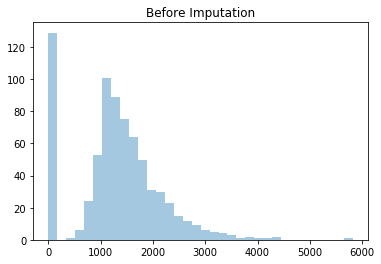

In [15]:
sns.distplot(X_train[:, 0], kde=False)
plt.title("Before Imputation")

C:\Users\nowling\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'After Imputation')

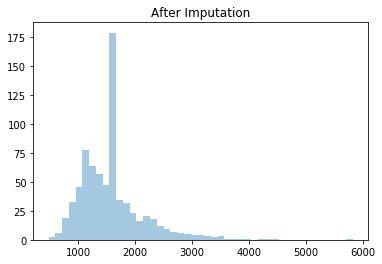

In [16]:
sns.distplot(X_train_imputed[:, 0], kde=False)
plt.title("After Imputation")

Machine learning models can be sensitive to differences in scales between variables.  Before we fit the model, we need to scale the squared footage so the average is around 0 and the standard deviation is around 1.  We can do this using the `StandardScaler` transformer in Scikit Learn. 

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

Let's compare the distributions before and after to see what has changed.

C:\Users\nowling\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Before Scaling')

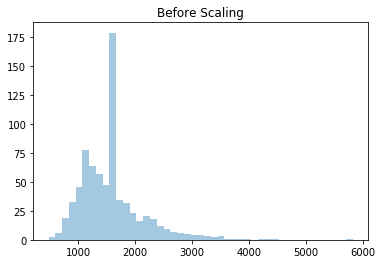

In [18]:
sns.distplot(X_train_imputed[:, 0], kde=False)
plt.title("Before Scaling")

C:\Users\nowling\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'After Scaling')

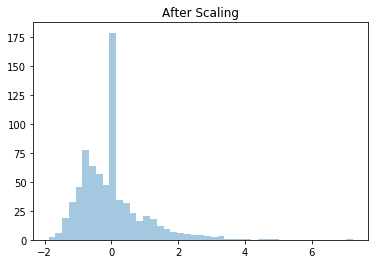

In [19]:
sns.distplot(X_train_scaled[:, 0], kde=False)
plt.title("After Scaling")

Note that the shape of the distribution has not changed.  Rather it has been shifted so that the mean is 0 and the magnitude of the values have been scaled.

Now, we can build a model.

In [20]:
simple_lr = SGDRegressor(max_iter=5000)
simple_lr.fit(X_train_scaled, y_train)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=5000, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

Next, we will use the simple LR model to predict the prices of the transactions in the testing set and calculate our metrics.

In [21]:
pred_prices_simple_test = simple_lr.predict(X_test_scaled)
simple_mse = mean_squared_error(y_test, pred_prices_simple_test)
simple_rmse = np.sqrt(simple_mse)

print("Base Model MSE:", base_mse)
print("Base Model RMSE:", base_rmse)
print()
print("Simple Model RMSE:", simple_mse)
print("Simple Model MSE:", simple_rmse)

Base Model MSE: 19650625858.44129
Base Model RMSE: 140180.69003411738

Simple Model RMSE: 11742763191.74384
Simple Model MSE: 108364.03089468312


Our average error has decreased by quite a bit.  Let's see how the predicted prices compare to the true prices using a plot.

Text(0,0.5,'Predicted Price')

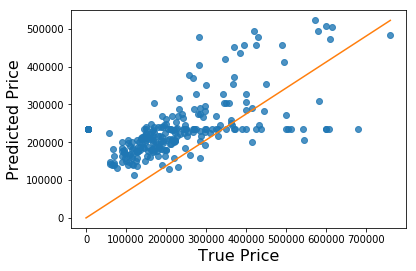

In [23]:
sns.regplot(x=y_test, y=pred_prices_simple_test, fit_reg=False)
plt.plot([0, np.max(y_test)], [0, np.max(pred_prices_simple_test)])
plt.xlabel("True Price", fontsize=16)
plt.ylabel("Predicted Price", fontsize=16)

We now see some correlation between the true prices and predicted prices.  By using the squared footage, we are able to get more accurate predicted prices than if we only used the average price.